In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## MSEIRS Equations
Reference: 
- https://www.freecodecamp.org/news/how-to-model-an-epidemic-with-r/ 
- https://repositorium.sdum.uminho.pt/bitstream/1822/60583/1/preprint.pdf

In our MSEIRS system, we make the below assumptions:
1. The death rate and born rate are the same, which means the number of population will not change over time.
2. Both passive maternally-derived immunity and temporary immunity weakened at the same rate

In [2]:
# define the SEIR function
def MSEIRS_model(time, current_state, beta, sigma, gamma, delta, lam):
    M, S, E, I, R = current_state
    
    N = M + S + E + I + R
    # -weakend rate * infant with immunity + new born rate * new born with immunity prob
    dM = -delta * M + lam * I * R / N
    # - contact rate * contact probabilities 
    # + new born losing passive immunity rate 
    # + new born rate * new born without immunity prob
    dS = -(beta * S * I) / N + delta * M + lam * I * (1 - R / N) + delta * R
    dE = (beta * S * I) / N - sigma * E
    # infectious rate - recovery rate - death rate
    dI = sigma * E - gamma * I - lam * I
    # recovery rate + immunity weakened rate
    dR = gamma * I - delta * R
    
    return [dM, dS, dE, dI, dR]

## Initial Parameters
beta = 0.5 : Transmission/Contact rate  
sigma = 0.25 : Infectious rate  
gamma = 0.2 : Recovery rate  
delta = 0.1 : Immunity weakened rate  
lambda = 0.05 : Birth/Death rate 
days = 365 : Number of days to simulate

In [3]:
# initialise parameters
params = {
    'delta': 0.1,
    'beta': 0.5,
    'sigma': 0.25,
    'gamma': 0.2,
    'lam': 0.05
}

times = np.arange(0, 366)

## S - Susceptible, E - Exposed, I - Infectious, R - Recovered
M = 0: The initial number of new born with maternal immunity is set to 0.  
S = 999999: The initial number of susceptible individuals is set to 999,999.  
E = 1: The initial number of exposed individuals is set to 1.  
I = 0: The initial number of infectious individuals is set to 0.  
R = 0: The initial number of recovered individuals is set to 0.  

In [4]:
# initialise the initialise state of SEIR
initial_state = [0, 999999, 1, 0, 0]

## solve_ivp
To solve equation with respect to time

In [5]:
from scipy.integrate import solve_ivp

In [6]:
# Solve the SEIR model using solve_ivp
solution = solve_ivp(lambda t, y: MSEIRS_model(t, y, **params), [times[0], times[-1]], initial_state, t_eval=times)

## Summary of model's statistics

In [7]:
# Access the solution arrays
M = solution.y[0]
S = solution.y[1]
E = solution.y[2]
I = solution.y[3]
R = solution.y[4]

# Calculate summary statistics
summary_M = np.mean(M), np.min(R), np.max(R), np.percentile(R, [25, 50, 75])
summary_S = np.mean(S), np.min(S), np.max(S), np.percentile(S, [25, 50, 75])
summary_E = np.mean(E), np.min(E), np.max(E), np.percentile(E, [25, 50, 75])
summary_I = np.mean(I), np.min(I), np.max(I), np.percentile(I, [25, 50, 75])
summary_R = np.mean(R), np.min(R), np.max(R), np.percentile(R, [25, 50, 75])

list_summary = [summary_M, summary_S, summary_E, summary_I, summary_R]
summary_names = ['M', 'S', 'E', 'I', 'R']

for i in range(len(list_summary)):
    print("Summary of", summary_names[i], ":")
    print("Mean:", list_summary[i][0])
    print("Minimum:", list_summary[i][1])
    print("Maximum:", list_summary[i][2])
    print("25th Percentile:", list_summary[i][3][0])
    print("50th Percentile (Median):", list_summary[i][3][1])
    print("75th Percentile:", list_summary[i][3][2])
    print()


Summary of M :
Mean: 9166.542410721022
Minimum: 0.0
Maximum: 252928.14100600395
25th Percentile: 4351.727327386307
50th Percentile (Median): 242534.71265863732
75th Percentile: 242654.6535807966

Summary of S :
Mean: 665087.734951661
Minimum: 477812.0188290193
Maximum: 999999.0
25th Percentile: 499977.3003099578
50th Percentile (Median): 500095.4486719167
75th Percentile: 985075.9256793731

Summary of E :
Mean: 84078.09298385859
Minimum: 0.7639702705028147
Maximum: 136110.2425025267
25th Percentile: 6178.261875744776
50th Percentile (Median): 121198.36750691905
75th Percentile: 121355.477513752

Summary of I :
Mean: 82774.67354481466
Minimum: 0.0
Maximum: 134300.56993531843
25th Percentile: 4390.9364020050125
50th Percentile (Median): 121241.37300019307
75th Percentile: 121375.40995049637

Summary of R :
Mean: 158892.95610894499
Minimum: 0.0
Maximum: 252928.14100600395
25th Percentile: 4351.727327386307
50th Percentile (Median): 242534.71265863732
75th Percentile: 242654.6535807966



## Infection peak when there is no intervention taken

In [9]:
# Create a dataframe from the solution arrays
df_model = pd.DataFrame(
    {
        "Time": times,
        "Maternal Immunity": solution.y[0],
        "Susceptible": solution.y[1],
        "Exposed": solution.y[2],
        "Infectious": solution.y[3],
        "Recovered": solution.y[4],
    }
)

# Extract the Infectious column
df_infections = df_model["Infectious"]

# Obtain the max number of people infected
peak_infections = df_infections.max()

# Obtain the n-day when the number of people infected is max
peak_time = df_infections.idxmax()

print(
    "The number of infections peaked on day",
    peak_time,
    "with",
    round(peak_infections),
    "people.",
)

# Extract the Exposed column
df_exposed = df_model['Exposed']

# Obtain the max number of people exposed
peak_exposed = df_exposed.max()

# Obtain the n-day when the number of people exposed is max
peak_time_exposed = df_exposed.idxmax()

print(
    "The number of exposed peaked on day",
    peak_time_exposed,
    "with",
    round(peak_exposed),
    "people.",
)

# Extract the Susceptible column
df_sus = df_model['Susceptible']

# Obtain the max number of people exposed
peak_sus = df_sus.min()

# Obtain the n-day when the number of people exposed is max
peak_time_sus = df_sus.idxmin()

print(
    "The number of susceptible lowest on day",
    peak_time_sus,
    "with",
    round(peak_sus),
    "people.",
)

The number of infections peaked on day 146 with 134301 people.
The number of exposed peaked on day 140 with 136110 people.
The number of susceptible lowest on day 154 with 477812 people.


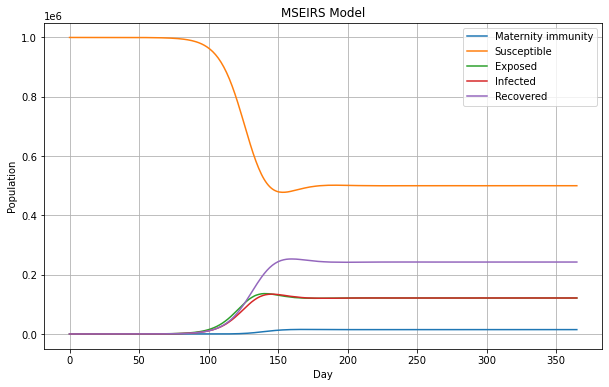

In [10]:
# Plotting the MSEIRS model
plt.figure(figsize=(10, 6))
plt.plot(times, M, label='Maternity immunity')
plt.plot(times, S, label='Susceptible')
plt.plot(times, E, label='Exposed')
plt.plot(times, I, label='Infected')
plt.plot(times, R, label='Recovered')
plt.xlabel('Day')
plt.ylabel('Population')
plt.title('MSEIRS Model')
plt.legend()
plt.grid(True)

# # Adding horizontal and vertical lines to the peak infectious point
# point_x = peak_time  
# point_y = peak_infections

# # Horizontal line
# plt.axhline(y=point_y, color='black', linestyle='--')  
# # Vertical line
# plt.axvline(x=point_x, color='black', linestyle='--')  

# # Marking the point
# plt.scatter(point_x, point_y, color='black', marker='o') 

# # Adding text annotation for the point coordinates
# plt.text(point_x + 5, point_y + 30000, f'({point_x}, {round(point_y)})', color='black')

# # Adding horizontal and vertical lines to the peak exposed point
# point_x_e = peak_time_exposed  
# point_y_e = peak_exposed

# # Horizontal line
# plt.axhline(y=point_y_e, color='b', linestyle='--')  
# # Vertical line
# plt.axvline(x=point_x_e, color='b', linestyle='--')  

# # Marking the point
# plt.scatter(point_x_e, point_y_e, color='b', marker='o') 

# # Adding text annotation for the point coordinates
# plt.text(point_x_e - 50, point_y_e + 30000, f'({point_x_e}, {round(point_y_e)})', color='b')

# # Adding horizontal and vertical lines to the min susceptible point
# point_x_s = peak_time_sus  
# point_y_s = peak_sus

# # Horizontal line
# plt.axhline(y=point_y_s, color='y', linestyle='--')  
# # Vertical line
# plt.axvline(x=point_x_s, color='y', linestyle='--')  

# # Marking the point
# plt.scatter(point_x_s, point_y_s, color='y', marker='o') 

# # Adding text annotation for the point coordinates
# plt.text(point_x_s - 50, point_y_s + 30000, f'({point_x_s}, {round(point_y_s)})', color='y')

plt.show()